In [3]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
imagedir = "Datasets/Detection/Byteplots"

In [5]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [6]:
X.shape

(3931, 224, 224, 3)

In [7]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [8]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [9]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = VGG19(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 3144 samples, validate on 787 samples
Epoch 1/100
3144/3144 [==============================] - 104s 33ms/step - loss: 8.0506 - acc: 0.4968 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 2/100
3144/3144 [==============================] - 94s 30ms/step - loss: 8.1411 - acc: 0.4949 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 3/100
3144/3144 [==============================] - 94s 30ms/step - loss: 8.1411 - acc: 0.4949 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 4/100
3144/3144 [==============================] - 94s 30ms/step - loss: 8.1411 - acc: 0.4949 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 5/100
3144/3144 [==============================] - 94s 30ms/step - loss: 8.1411 - acc: 0.4949 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 6/100
3144/3144 [==============================] - 97s 31ms/step - loss: 8.1411 - acc: 0.4949 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 7/100
3144/3144 [==============================] - 96s 31ms/step - loss: 8.1411 - acc: 0.4949 - val_loss: 8.1512 - val_acc: 

3144/3144 [==============================] - 94s 30ms/step - loss: 8.1411 - acc: 0.4949 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 61/100
3144/3144 [==============================] - 95s 30ms/step - loss: 8.1411 - acc: 0.4949 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 62/100
3144/3144 [==============================] - 96s 30ms/step - loss: 8.1411 - acc: 0.4949 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 63/100
3144/3144 [==============================] - 95s 30ms/step - loss: 8.1411 - acc: 0.4949 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 64/100
3144/3144 [==============================] - 97s 31ms/step - loss: 8.1411 - acc: 0.4949 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 65/100
3144/3144 [==============================] - 97s 31ms/step - loss: 8.1411 - acc: 0.4949 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 66/100
3144/3144 [==============================] - 94s 30ms/step - loss: 8.1411 - acc: 0.4949 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 67/100
3144/3144 [=======================

3145/3145 [==============================] - 88s 28ms/step - loss: 7.9745 - acc: 0.5052 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 19/100
3145/3145 [==============================] - 87s 28ms/step - loss: 7.9745 - acc: 0.5052 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 20/100
3145/3145 [==============================] - 86s 27ms/step - loss: 7.9745 - acc: 0.5052 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 21/100
3145/3145 [==============================] - 86s 27ms/step - loss: 7.9745 - acc: 0.5052 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 22/100
3145/3145 [==============================] - 86s 27ms/step - loss: 7.9745 - acc: 0.5052 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 23/100
3145/3145 [==============================] - 86s 27ms/step - loss: 7.9745 - acc: 0.5052 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 24/100
3145/3145 [==============================] - 88s 28ms/step - loss: 7.9745 - acc: 0.5052 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 25/100
3145/3145 [=======================

3145/3145 [==============================] - 88s 28ms/step - loss: 7.9745 - acc: 0.5052 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 78/100
3145/3145 [==============================] - 89s 28ms/step - loss: 7.9745 - acc: 0.5052 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 79/100
3145/3145 [==============================] - 87s 28ms/step - loss: 7.9745 - acc: 0.5052 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 80/100
3145/3145 [==============================] - 89s 28ms/step - loss: 7.9745 - acc: 0.5052 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 81/100
3145/3145 [==============================] - 89s 28ms/step - loss: 7.9745 - acc: 0.5052 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 82/100
3145/3145 [==============================] - 88s 28ms/step - loss: 7.9745 - acc: 0.5052 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 83/100
3145/3145 [==============================] - 85s 27ms/step - loss: 7.9745 - acc: 0.5052 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 84/100
3145/3145 [=======================

3145/3145 [==============================] - 89s 28ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 36/100
3145/3145 [==============================] - 86s 27ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 37/100
3145/3145 [==============================] - 89s 28ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 38/100
3145/3145 [==============================] - 88s 28ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 39/100
3145/3145 [==============================] - 87s 28ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 40/100
3145/3145 [==============================] - 88s 28ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 41/100
3145/3145 [==============================] - 88s 28ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 42/100
3145/3145 [=======================

3145/3145 [==============================] - 88s 28ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 95/100
3145/3145 [==============================] - 85s 27ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 96/100
3145/3145 [==============================] - 85s 27ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 97/100
3145/3145 [==============================] - 89s 28ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 98/100
3145/3145 [==============================] - 88s 28ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 99/100
3145/3145 [==============================] - 88s 28ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 100/100
786/786 [==============================] - 9s 11ms/step
[2] Test acurracy: 0.4949 (8728.1709 s)
Train on 3145 samples, validate on 786 samples
Epoch 1/100
3145/3145 [=====

3145/3145 [==============================] - 91s 29ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 53/100
3145/3145 [==============================] - 94s 30ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 54/100
3145/3145 [==============================] - 93s 30ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 55/100
3145/3145 [==============================] - 90s 29ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 56/100
3145/3145 [==============================] - 92s 29ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 57/100
3145/3145 [==============================] - 91s 29ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 58/100
3145/3145 [==============================] - 89s 28ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 59/100
3145/3145 [=======================

3145/3145 [==============================] - 98s 31ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 11/100
3145/3145 [==============================] - 100s 32ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 12/100
3145/3145 [==============================] - 94s 30ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 13/100
3145/3145 [==============================] - 92s 29ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 14/100
3145/3145 [==============================] - 97s 31ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 15/100
3145/3145 [==============================] - 96s 31ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 16/100
3145/3145 [==============================] - 97s 31ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 17/100
3145/3145 [======================

3145/3145 [==============================] - 52s 17ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 70/100
3145/3145 [==============================] - 52s 17ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 71/100
3145/3145 [==============================] - 53s 17ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 72/100
3145/3145 [==============================] - 53s 17ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 73/100
3145/3145 [==============================] - 54s 17ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 74/100
3145/3145 [==============================] - 53s 17ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 75/100
3145/3145 [==============================] - 53s 17ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 76/100
3145/3145 [=======================

In [10]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.4968


In [11]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

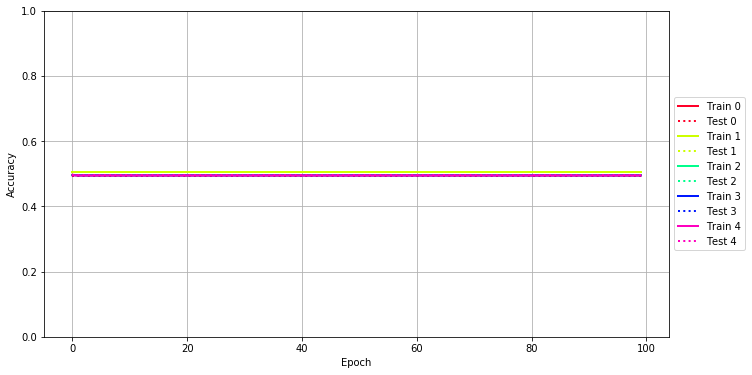

In [12]:
plot_acc(history)

In [13]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

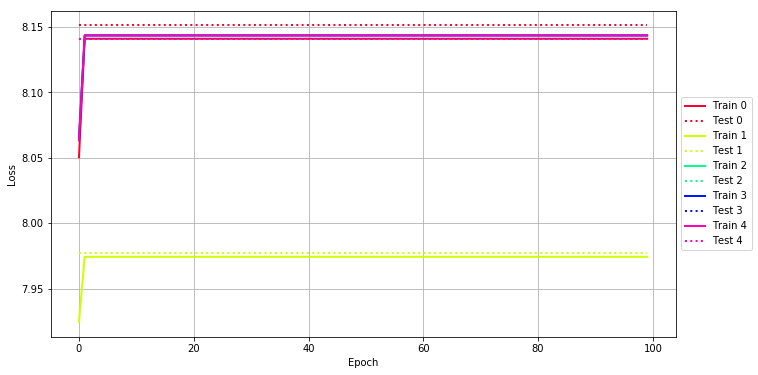

In [14]:
plot_loss(history)

Plotting the confusion matrix


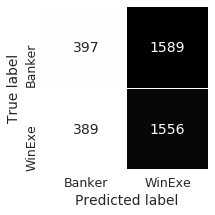

In [15]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


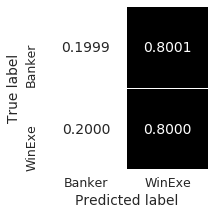

In [16]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.4f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
for h in history:
    print(h.history)

{'val_acc': [0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.4942820838627

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

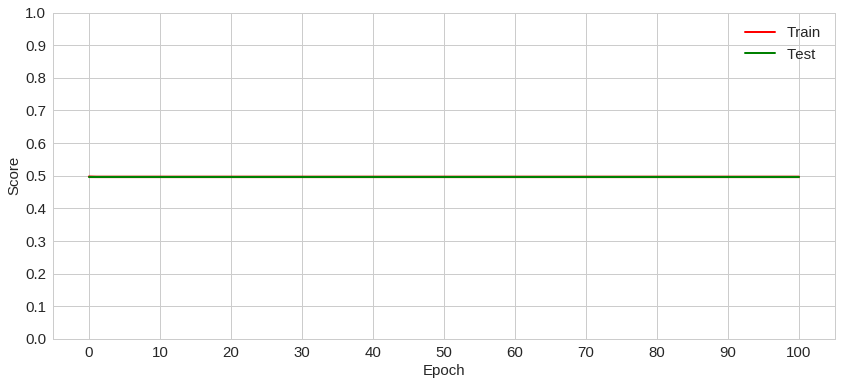

In [19]:
plot_mean_acc(history)

In [20]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

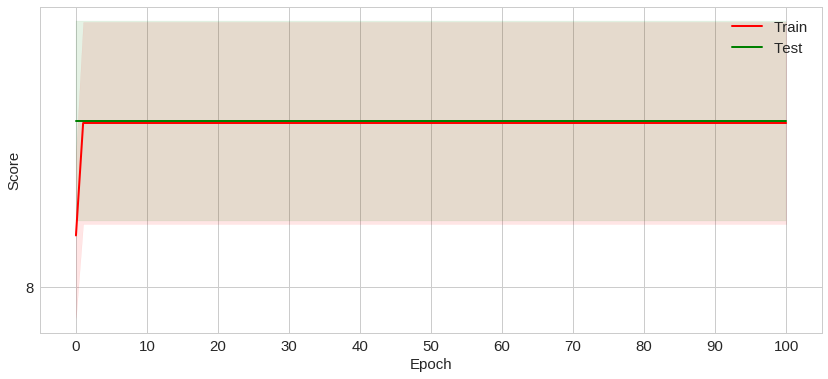

In [21]:
plot_mean_loss(history)

In [23]:
hist = [{'val_acc': [0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277], 'val_loss': [8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458], 'loss': [8.050571868134515, 8.141073719539108, 8.141073724392413, 8.141073702552543, 8.141073712259152, 8.141073704979195, 8.141073758365543, 8.141073748658934, 8.141073685565978, 8.141073751085587, 8.141073717112457, 8.14107369769924, 8.141073707405848, 8.141073668579413, 8.141073746232284, 8.141073738952326, 8.14107373167237, 8.141073709832499, 8.141073729245717, 8.141073736525675, 8.141073678286022, 8.141073690419281, 8.141073709832499, 8.141073736525675, 8.141073709832499, 8.141073675859369, 8.14107374380563, 8.141073746232284, 8.14107375351224, 8.141073695272587, 8.141073717112457, 8.141073678286022, 8.141073724392413, 8.141073729245717, 8.141073736525675, 8.141073690419281, 8.141073671006064, 8.141073724392413, 8.141073765645501, 8.141073724392413, 8.141073695272587, 8.141073734099022, 8.141073717112457, 8.14107369769924, 8.14107369769924, 8.141073709832499, 8.141073695272587, 8.141073736525675, 8.141073724392413, 8.14107370012589, 8.141073709832499, 8.14107363217963, 8.141073704979195, 8.14107366615276, 8.141073724392413, 8.141073738952326, 8.141073685565978, 8.141073772925457, 8.141073678286022, 8.14107369769924, 8.141073758365543, 8.141073719539108, 8.14107375351224, 8.141073704979195, 8.141073709832499, 8.141073729245717, 8.141073724392413, 8.141073785058717, 8.141073695272587, 8.141073763218849, 8.141073712259152, 8.14107369769924, 8.141073741378978, 8.141073704979195, 8.141073695272587, 8.141073719539108, 8.141073734099022, 8.141073685565978, 8.141073675859369, 8.141073748658934, 8.141073690419281, 8.141073736525675, 8.141073738952326, 8.141073646739542, 8.141073702552543, 8.141073736525675, 8.14107370012589, 8.141073709832499, 8.141073704979195, 8.141073726819066, 8.141073760792196, 8.141073770498805, 8.14107375351224, 8.141073719539108, 8.141073763218849, 8.141073768072152, 8.141073712259152, 8.141073709832499, 8.141073741378978, 8.141073726819066], 'acc': [0.49681933842239184, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827]},
{'val_acc': [0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731], 'val_loss': [7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728], 'loss': [7.924692157569485, 7.974485430391491, 7.9744854173523825, 7.974485453134121, 7.974485402493864, 7.974485435243252, 7.974485470721755, 7.9744854206879685, 7.974485466173229, 7.974485399764748, 7.9744854467661845, 7.97448541007474, 7.974485427055905, 7.974485444188686, 7.9744854886126255, 7.974485475573517, 7.974485475725134, 7.974485461018233, 7.974485453134121, 7.974485383693288, 7.974485398248572, 7.974485441611188, 7.974485425539729, 7.974485431907666, 7.9744853833900535, 7.974485458289117, 7.974485431907666, 7.974485419929881, 7.974485457985883, 7.974485427055905, 7.974485407952095, 7.974485436759427, 7.9744854807285135, 7.974485396429162, 7.974485424023554, 7.97448544646295, 7.974485456469707, 7.974485441307953, 7.974485441611188, 7.9744854094682704, 7.9744854513147105, 7.974485427207522, 7.97448537868991, 7.9744854807285135, 7.974485474057341, 7.9744854513147105, 7.974485457985883, 7.974485465869995, 7.974485483760864, 7.974485430391491, 7.974485425539729, 7.974485474360577, 7.974485398248572, 7.974485438578838, 7.974485402948716, 7.974485417655617, 7.974485453134121, 7.974485454650297, 7.974485440095013, 7.97448542735914, 7.974485396429162, 7.974485437365897, 7.974485437062662, 7.974485419171793, 7.97448548709645, 7.974485383693288, 7.9744854886126255, 7.974485431907666, 7.974485495283797, 7.9744854901288, 7.974485437062662, 7.974485461018233, 7.974485422204143, 7.974485427055905, 7.974485407800477, 7.974485431907666, 7.974485404616509, 7.974485438578838, 7.974485437062662, 7.974485471024991, 7.974485403100334, 7.9744854128038565, 7.974485427055905, 7.974485479212338, 7.974485444340304, 7.974485467689405, 7.974485417655617, 7.974485381873878, 7.974485402797098, 7.974485464353819, 7.974485442824129, 7.97448546799264, 7.9744854902804185, 7.974485422355761, 7.974485397945338, 7.974485425539729, 7.974485441004719, 7.9744854807285135, 7.974485408558565, 7.974485452527651], 'acc': [0.5052464229029578, 0.5052464229503383, 0.5052464229029578, 0.50524642292191, 0.5052464229029578, 0.5052464229503383, 0.5052464229029578, 0.5052464229503383, 0.5052464229692905, 0.50524642292191, 0.5052464229692905, 0.5052464228934818, 0.5052464229029578, 0.5052464229313861, 0.5052464229503383, 0.5052464229029578, 0.5052464229313861, 0.5052464229029578, 0.50524642292191, 0.5052464229692905, 0.5052464229692905, 0.5052464229029578, 0.5052464229503383, 0.5052464229029578, 0.5052464229029578, 0.5052464229029578, 0.5052464229029578, 0.5052464229313861, 0.50524642292191, 0.5052464229029578, 0.5052464229692905, 0.5052464229029578, 0.5052464229692905, 0.5052464229503383, 0.50524642292191, 0.5052464229029578, 0.5052464229692905, 0.5052464229029578, 0.5052464229029578, 0.50524642292191, 0.5052464229029578, 0.5052464229313861, 0.5052464229313861, 0.5052464229692905, 0.5052464229503383, 0.5052464229029578, 0.50524642292191, 0.5052464229029578, 0.5052464229503383, 0.5052464228958508, 0.5052464229503383, 0.5052464228982197, 0.5052464229692905, 0.50524642292191, 0.5052464229313861, 0.5052464229692905, 0.50524642292191, 0.5052464229503383, 0.5052464229503383, 0.5052464229692905, 0.5052464229503383, 0.5052464228958508, 0.5052464229692905, 0.50524642292191, 0.50524642292191, 0.5052464229692905, 0.5052464229503383, 0.5052464229029578, 0.5052464229692905, 0.5052464229029578, 0.5052464229692905, 0.5052464229029578, 0.5052464229029578, 0.5052464229029578, 0.5052464229313861, 0.5052464229029578, 0.50524642292191, 0.50524642292191, 0.5052464229692905, 0.5052464229692905, 0.5052464229692905, 0.5052464229692905, 0.5052464229029578, 0.5052464228982197, 0.5052464229692905, 0.50524642292191, 0.5052464229692905, 0.5052464229503383, 0.5052464229029578, 0.5052464229503383, 0.5052464228982197, 0.5052464229029578, 0.5052464229313861, 0.5052464229313861, 0.5052464229029578, 0.5052464229503383, 0.50524642292191, 0.5052464229692905, 0.5052464229503383, 0.5052464228982197]},
{'val_acc': [0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827], 'val_loss': [8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917], 'loss': [8.068746044601658, 8.143610154653771, 8.143610196803447, 8.143610144950248, 8.143610150105244, 8.14361013191114, 8.1436101479826, 8.143610152834361, 8.143610077632061, 8.14361017254464, 8.143610141008192, 8.143610132214375, 8.143610181944927, 8.143610153137596, 8.143610063986483, 8.143610094916461, 8.143610182096545, 8.143610107652334, 8.143610137066137, 8.14361011098792, 8.143610165873469, 8.143610106742628, 8.143610157837738, 8.143610138279076, 8.14361017072523, 8.14361014980201, 8.14361013858231, 8.143610125543203, 8.143610104316748, 8.143610094916461, 8.143610133427314, 8.1436101367629, 8.14361012387541, 8.143610123723793, 8.143610099768221, 8.143610157989356, 8.143610107652334, 8.143610128575554, 8.143610104619983, 8.143610144950248, 8.143610177244783, 8.143610162537883, 8.14361014980201, 8.143610162841117, 8.143610151318185, 8.143610183157868, 8.143610125846438, 8.143610165873469, 8.143610113717035, 8.14361015768612, 8.143610116749386, 8.143610089761465, 8.14361013373055, 8.143610088245289, 8.143610109509648, 8.143610104619983, 8.143610141917897, 8.143610102800572, 8.14361012387541, 8.143610135246727, 8.14361013858231, 8.14361015162142, 8.143610112504096, 8.143610154653771, 8.14361015768612, 8.143610065805893, 8.143610106439393, 8.143610119023649, 8.143610133427314, 8.143610118872031, 8.1436101306982, 8.143610111291155, 8.143610152834361, 8.143610157837738, 8.143610138279076, 8.143610153137596, 8.14361017254464, 8.143610141917897, 8.14361017254464, 8.143610140098486, 8.143610094613225, 8.143610165873469, 8.143610099464986, 8.143610148285834, 8.143610108562038, 8.143610065805893, 8.143610133427314, 8.143610107652334, 8.14361013373055, 8.143610127969083, 8.143610148285834, 8.1436101367629, 8.143610162537883, 8.143610083393527, 8.143610167389644, 8.143610089761465, 8.143610120691442, 8.143610138430693, 8.143610196651828, 8.14361013191114], 'acc': [0.4947535771159944, 0.49475357713494655, 0.49475357718232704, 0.49475357713494655, 0.4947535771159944, 0.49475357716337487, 0.4947535771159944, 0.4947535771159944, 0.4947535771159944, 0.49475357718232704, 0.49475357718232704, 0.49475357711125634, 0.4947535771159944, 0.49475357718232704, 0.49475357716337487, 0.49475357718232704, 0.49475357714442264, 0.49475357716337487, 0.49475357711125634, 0.49475357713494655, 0.49475357716337487, 0.4947535771065183, 0.49475357714442264, 0.4947535771159944, 0.49475357716337487, 0.49475357713494655, 0.49475357718232704, 0.49475357713494655, 0.4947535771159944, 0.49475357718232704, 0.4947535771159944, 0.49475357716337487, 0.49475357714442264, 0.4947535771159944, 0.49475357718232704, 0.49475357718232704, 0.4947535771088873, 0.4947535771159944, 0.49475357718232704, 0.49475357713494655, 0.49475357714442264, 0.4947535771159944, 0.49475357713494655, 0.49475357718232704, 0.49475357716337487, 0.49475357711125634, 0.4947535771159944, 0.49475357716337487, 0.4947535771159944, 0.4947535771159944, 0.49475357718232704, 0.4947535771159944, 0.49475357718232704, 0.4947535771088873, 0.4947535771065183, 0.49475357718232704, 0.49475357711125634, 0.49475357716337487, 0.49475357714442264, 0.49475357713494655, 0.49475357718232704, 0.49475357711125634, 0.49475357716337487, 0.49475357713494655, 0.4947535771159944, 0.49475357718232704, 0.4947535771159944, 0.49475357714442264, 0.4947535771159944, 0.4947535771159944, 0.4947535771159944, 0.4947535771159944, 0.4947535771159944, 0.49475357714442264, 0.4947535771159944, 0.49475357718232704, 0.49475357718232704, 0.49475357711125634, 0.49475357718232704, 0.49475357713494655, 0.4947535771159944, 0.4947535771088873, 0.4947535771159944, 0.49475357718232704, 0.49475357713494655, 0.49475357718232704, 0.4947535771159944, 0.49475357716337487, 0.49475357718232704, 0.49475357713494655, 0.49475357718232704, 0.49475357716337487, 0.4947535771159944, 0.49475357716337487, 0.4947535771159944, 0.4947535771159944, 0.49475357713494655, 0.49475357714442264, 0.49475357714442264, 0.49475357716337487]},
{'val_acc': [0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827], 'val_loss': [8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917], 'loss': [8.06352689967436, 8.143610162841117, 8.143610119175266, 8.143610169209055, 8.143610120084972, 8.143610123799602, 8.14361013373055, 8.143610088245289, 8.14361013858231, 8.143610161021707, 8.143610187706393, 8.143610141917897, 8.14361009794881, 8.143610186796689, 8.143610103103807, 8.143610119175266, 8.143610138279076, 8.1436101479826, 8.143610117355855, 8.143610125543203, 8.143610143434072, 8.143610109471744, 8.14361012887879, 8.143610144950248, 8.143610167389644, 8.143610120691442, 8.143610089761465, 8.14361012887879, 8.143610120691442, 8.143610122510852, 8.143610114323506, 8.14361007035442, 8.143610143130838, 8.143610109471744, 8.143610122207617, 8.143610156473182, 8.143610089913082, 8.143610089761465, 8.143610130394965, 8.143610157837738, 8.143610161324942, 8.143610135929004, 8.143610094764844, 8.14361013433702, 8.14361016052895, 8.143610190132275, 8.143610099464986, 8.143610143130838, 8.143610135246727, 8.143610128575554, 8.14361012387541, 8.143610143130838, 8.14361009794881, 8.1436100900647, 8.14361013373055, 8.14361012387541, 8.14361013858231, 8.143610140098486, 8.14361012887879, 8.143610147679365, 8.143610135549961, 8.143610189525804, 8.143610122510852, 8.14361011402027, 8.14361013858231, 8.143610146466424, 8.143610138279076, 8.143610125543203, 8.143610143130838, 8.143610203474617, 8.1436101540473, 8.143610140401721, 8.143610143130838, 8.143610124027028, 8.143610130394965, 8.143610169815524, 8.143610116446151, 8.143610122207617, 8.143610165039572, 8.143610182248162, 8.143610104619983, 8.143610144950248, 8.143610138430693, 8.143610169891334, 8.143610089837273, 8.14361013191114, 8.14361009794881, 8.143610126490813, 8.143610101284397, 8.143610055799135, 8.143610120994676, 8.143610124027028, 8.14361012387541, 8.143610119175266, 8.143610121601148, 8.143610082787058, 8.143610146769658, 8.143610135246727, 8.143610152985978, 8.143610119781737], 'acc': [0.49538950719211744, 0.49475357718232704, 0.49475357718232704, 0.49475357713494655, 0.49475357711125634, 0.49475357712547047, 0.49475357718232704, 0.49475357716337487, 0.49475357718232704, 0.49475357716337487, 0.49475357716337487, 0.49475357711125634, 0.49475357716337487, 0.4947535771159944, 0.49475357711125634, 0.49475357718232704, 0.4947535771159944, 0.4947535771159944, 0.49475357716337487, 0.49475357713494655, 0.49475357718232704, 0.49475357718232704, 0.49475357718232704, 0.49475357713494655, 0.4947535771159944, 0.49475357713494655, 0.4947535771159944, 0.49475357718232704, 0.49475357713494655, 0.49475357711125634, 0.49475357718232704, 0.4947535771159944, 0.4947535771159944, 0.49475357718232704, 0.49475357716337487, 0.49475357711125634, 0.49475357714442264, 0.4947535771159944, 0.49475357713494655, 0.49475357714442264, 0.49475357711125634, 0.49475357712547047, 0.49475357714442264, 0.49475357716337487, 0.4947535772960402, 0.49475357716337487, 0.4947535771159944, 0.4947535771159944, 0.49475357713494655, 0.4947535771159944, 0.49475357714442264, 0.4947535771159944, 0.49475357716337487, 0.49475357718232704, 0.49475357718232704, 0.49475357714442264, 0.49475357718232704, 0.49475357713494655, 0.49475357718232704, 0.4947535771159944, 0.4947535771159944, 0.49475357718232704, 0.49475357711125634, 0.4947535771159944, 0.49475357718232704, 0.49475357716337487, 0.4947535771159944, 0.49475357713494655, 0.4947535771159944, 0.4947535771159944, 0.49475357711125634, 0.4947535771159944, 0.4947535771159944, 0.49475357718232704, 0.49475357713494655, 0.4947535771159944, 0.4947535771159944, 0.49475357716337487, 0.49475357712547047, 0.49475357718232704, 0.49475357718232704, 0.49475357713494655, 0.49475357714442264, 0.49475357712547047, 0.49475357712547047, 0.49475357716337487, 0.49475357716337487, 0.4947535771065183, 0.49475357713494655, 0.4947535771159944, 0.4947535771159944, 0.49475357718232704, 0.49475357714442264, 0.49475357718232704, 0.49475357718232704, 0.49475357718232704, 0.49475357711125634, 0.49475357713494655, 0.49475357714442264, 0.49475357716337487]},
{'val_acc': [0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827], 'val_loss': [8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917], 'loss': [8.063602256168432, 8.14361013373055, 8.143610065805893, 8.1436101367629, 8.143610138279076, 8.14361011583968, 8.143610119175266, 8.14361003639209, 8.14361012887879, 8.143610117355855, 8.143610156169945, 8.143610122207617, 8.143610140401721, 8.143610078541766, 8.143610118872031, 8.1436101479826, 8.143610119175266, 8.143610104619983, 8.143610143130838, 8.143610107652334, 8.143610180428752, 8.143610164357293, 8.14361012887879, 8.143610135549961, 8.14361013191114, 8.143610111291155, 8.143610065805893, 8.143610133427314, 8.143610086729113, 8.143610161021707, 8.143610141614662, 8.143610190132275, 8.143610156169945, 8.143610067322069, 8.143610141614662, 8.143610152834361, 8.143610128575554, 8.14361012387541, 8.143610179519047, 8.143610127059379, 8.143610114171889, 8.143610141614662, 8.14361013373055, 8.14361013191114, 8.14361013130467, 8.143610123723793, 8.143610082559631, 8.14361011402027, 8.143610104619983, 8.143610089761465, 8.143610180731987, 8.143610161021707, 8.143610182096545, 8.143610123723793, 8.14361017315111, 8.143610172241406, 8.143610078541766, 8.143610157837738, 8.14361015768612, 8.143610123723793, 8.1436101773964, 8.143610102800572, 8.143610167692879, 8.143610099464986, 8.143610148285834, 8.1436100900647, 8.143610114323506, 8.143610041243852, 8.143610120994676, 8.143610104316748, 8.143610122207617, 8.1436101773964, 8.14361011402027, 8.14361015768612, 8.143610104619983, 8.143610132214375, 8.14361009794881, 8.143610120691442, 8.143610091580875, 8.143610101587631, 8.143610109471744, 8.143610119781737, 8.143610178912576, 8.1436100900647, 8.143610177093166, 8.143610119175266, 8.143610092604293, 8.143610080361176, 8.143610068838244, 8.14361013858231, 8.143610135246727, 8.143610193467861, 8.143610186796689, 8.143610152834361, 8.1436101479826, 8.143610120994676, 8.143610124027028, 8.143610142524368, 8.143610130394965, 8.143610148892304], 'acc': [0.4953895072300218, 0.49475357718232704, 0.49475357718232704, 0.49475357716337487, 0.4947535771159944, 0.49475357713494655, 0.49475357718232704, 0.4947535771159944, 0.49475357718232704, 0.49475357716337487, 0.49475357716337487, 0.49475357716337487, 0.4947535771159944, 0.49475357716337487, 0.4947535771159944, 0.4947535771159944, 0.49475357718232704, 0.49475357718232704, 0.4947535771159944, 0.49475357716337487, 0.49475357716337487, 0.49475357713494655, 0.49475357718232704, 0.4947535771159944, 0.49475357716337487, 0.4947535771159944, 0.49475357718232704, 0.4947535771159944, 0.49475357713494655, 0.49475357716337487, 0.49475357716337487, 0.49475357716337487, 0.49475357716337487, 0.49475357713494655, 0.49475357716337487, 0.4947535771159944, 0.4947535771159944, 0.49475357714442264, 0.4947535771159944, 0.49475357716337487, 0.49475357714442264, 0.49475357716337487, 0.49475357718232704, 0.49475357716337487, 0.49475357718232704, 0.4947535771159944, 0.49475357712547047, 0.4947535771159944, 0.49475357718232704, 0.4947535771159944, 0.49475357711125634, 0.49475357716337487, 0.49475357714442264, 0.4947535771159944, 0.49475357716337487, 0.4947535771159944, 0.49475357716337487, 0.49475357714442264, 0.4947535771159944, 0.4947535771159944, 0.49475357718232704, 0.49475357716337487, 0.49475357718232704, 0.4947535771159944, 0.49475357718232704, 0.49475357718232704, 0.49475357718232704, 0.4947535771159944, 0.4947535771159944, 0.4947535771159944, 0.49475357716337487, 0.49475357718232704, 0.4947535771159944, 0.4947535771159944, 0.49475357718232704, 0.49475357711125634, 0.49475357716337487, 0.49475357713494655, 0.49475357713494655, 0.4947535771159944, 0.49475357718232704, 0.49475357716337487, 0.49475357713494655, 0.49475357718232704, 0.4947535771159944, 0.49475357718232704, 0.4947535772960402, 0.49475357718232704, 0.49475357716337487, 0.49475357718232704, 0.49475357713494655, 0.49475357713494655, 0.4947535771159944, 0.4947535771159944, 0.4947535771159944, 0.4947535771159944, 0.49475357718232704, 0.49475357713494655, 0.49475357713494655, 0.49475357716337487]}]

In [24]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc'])))

[0] Epoch: 0 - Max val_acc: 0.4943
[1] Epoch: 0 - Max val_acc: 0.5051
[2] Epoch: 0 - Max val_acc: 0.4949
[3] Epoch: 0 - Max val_acc: 0.4949
[4] Epoch: 0 - Max val_acc: 0.4949


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

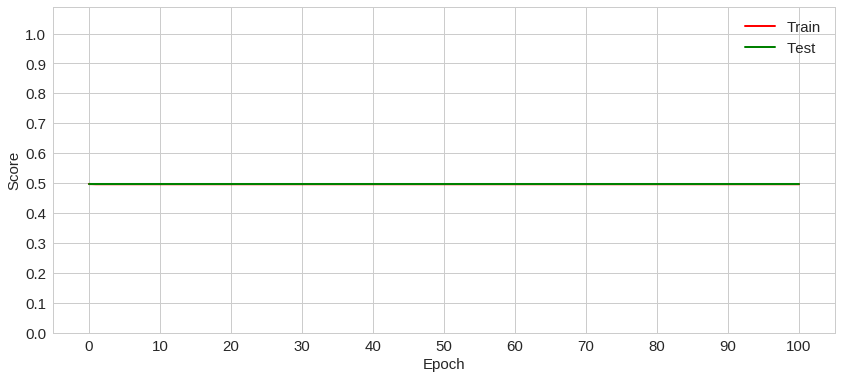

In [26]:
plot_mean_acc(hist)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

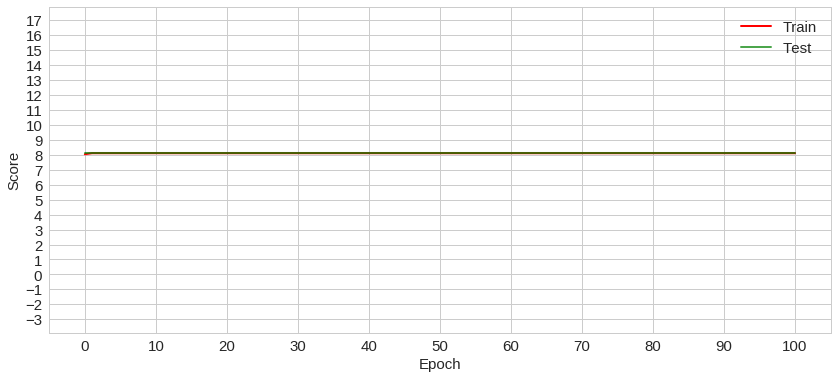

In [28]:
plot_mean_loss(hist)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean), np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean), np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-5, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

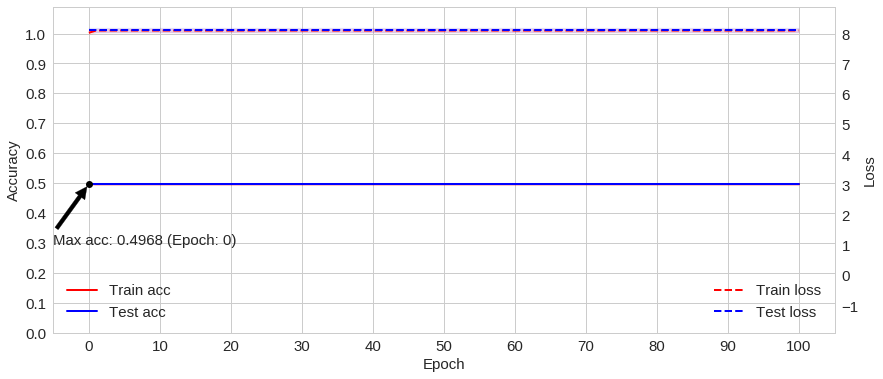

In [30]:
plot_mean(hist)